In [5]:
# --- Full Setup: LangSmith (optional), Tavily (optional), and OpenAI (required) ---

import os
import getpass
from langchain_openai import ChatOpenAI  # OpenAI chat model integration

# Optional: Enable LangSmith tracing for debugging chains (press Enter to skip)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LangSmith API key (optional): ")

# Optional: Set Tavily API key for web search capabilities (press Enter to skip)
os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key (optional): ")

# Required: Set OpenAI API key to access models like GPT-4o
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

# Initialize the OpenAI LLM you'll use for RAG
llm = ChatOpenAI(model="gpt-4o-mini")  # You can change this to "gpt-3.5-turbo" or "gpt-4" if needed

Enter your LangSmith API key (optional):  ········
Enter your Tavily API key (optional):  ········
Enter your OpenAI API key:  ········


In [7]:
# --- Initialize OpenAI's Embedding Model for text vectorization ---

from langchain_openai import OpenAIEmbeddings  # Import OpenAI's embeddings class

# Create an instance of the embedding model
# This will convert text into vector representations for use in retrieval
embeddings = OpenAIEmbeddings()

In [9]:
# --- Create a simple in-memory vector store for storing and retrieving document vectors ---

from langchain_core.vectorstores import InMemoryVectorStore  # Import in-memory store (no persistence)

# Initialize the vector store using the embedding model
# This is useful for small, temporary apps or testing purposes
vector_store = InMemoryVectorStore(embeddings)

In [11]:
# --- Imports ---
import bs4  # Used by the WebBaseLoader to parse HTML content
from langchain import hub  # For pulling shared prompt templates from LangChain Hub
from langchain_community.document_loaders import WebBaseLoader  # Loads web pages as documents
from langchain_core.documents import Document  # LangChain document format
from langchain_text_splitters import RecursiveCharacterTextSplitter  # Splits text into chunks
from langgraph.graph import START, StateGraph  # Used to define and run a LangGraph
from typing_extensions import List, TypedDict  # Type hinting for LangGraph state

# --- Load and Chunk Website Content ---
# Create a loader to pull the blog post content, filtering only the post-related HTML sections
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),  # Target blog URL
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")  # Only include relevant page sections
        )
    ),
)
docs = loader.load()  # Load the blog post as a list of Document objects

# Split the blog post into manageable text chunks for vector search
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# --- Index the Chunks ---
# Embed and store all the chunks into your vector store (e.g., Chroma or InMemoryVectorStore)
_ = vector_store.add_documents(documents=all_splits)

# --- Define Prompt for the Generator ---
# Pull a reusable RAG prompt template from LangChain Hub
prompt = hub.pull("rlm/rag-prompt")

# --- Define App State Structure ---
# This defines the data that moves through the RAG chain: question in, context in, answer out
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# --- Define Retrieval Step ---
# Takes the user question and retrieves the most relevant document chunks from the vector store
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

# --- Define Generation Step ---
# Uses the prompt and retrieved docs to generate an answer via the chat model
def generate(state: State):
    # Combine the retrieved chunks into one string for context
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    
    # Fill in the prompt template with the question and the context
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    
    # Generate the final answer using the LLM
    response = llm.invoke(messages)
    return {"answer": response.content}

# --- Compile LangGraph ---
# Set up the graph of your RAG workflow with defined steps
graph_builder = StateGraph(State).add_sequence([retrieve, generate])

# Connect the starting point to the first step in the chain
graph_builder.add_edge(START, "retrieve")

# Compile the graph into an executable app
graph = graph_builder.compile()

# --- Run the RAG App with a Test Question ---
response = graph.invoke({"question": "What is Task Decomposition?"})

# Print the generated answer
print(response["answer"])

USER_AGENT environment variable not set, consider setting it to identify your requests.


Task decomposition is the process of breaking a complicated task into smaller, manageable steps. It utilizes techniques like Chain of Thought (CoT) and Tree of Thoughts to enhance model performance by prompting the model to think step by step. This approach allows for more efficient problem-solving and provides insight into the model's reasoning process.


In [13]:
import bs4  # BeautifulSoup for parsing HTML
from langchain_community.document_loaders import WebBaseLoader  # Loads webpages as LangChain Documents

# --- Define which HTML content to keep ---
# This tells BeautifulSoup to only keep specific parts of the page (by class name)
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))

# --- Set up the web document loader ---
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),  # Target blog URL
    bs_kwargs={"parse_only": bs4_strainer},  # Apply the strainer to filter out unnecessary HTML
)

# --- Load the blog post into a LangChain Document object ---
docs = loader.load()  # Returns a list of one Document, since it's one blog post

# --- Check and print the result ---
assert len(docs) == 1  # Ensures we got exactly one document
print(f"Total characters: {len(docs[0].page_content)}")  # Prints the total length of the raw page content

Total characters: 43130


In [15]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [17]:
from langchain_text_splitters import RecursiveCharacterTextSplitter  # Recommended splitter for general use

# --- Initialize the text splitter ---
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,        # Max length of each chunk in characters
    chunk_overlap=200,      # Overlap between chunks to preserve context at boundaries
    add_start_index=True,   # Adds metadata indicating where each chunk starts in the original document
)

# --- Split the loaded document into smaller chunks ---
all_splits = text_splitter.split_documents(docs)  # Returns a list of Document objects

# --- Output the number of resulting chunks ---
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


In [19]:
# --- Store the document chunks in the vector store by embedding and indexing them ---

# Each chunk from `all_splits` is embedded and stored using the `vector_store` you initialized earlier
# The method returns a list of unique document IDs assigned by the store
document_ids = vector_store.add_documents(documents=all_splits)

# Print the first few document IDs to confirm indexing worked
print(document_ids[:3])

['21a85387-d16f-4cf8-b730-cc22ac99aa2d', 'bf4f2851-87c3-45a4-a8e9-4892da63bf5b', '4bec8aec-0f3e-4f0f-955f-445f9e77e914']


In [21]:
from langchain import hub  # LangChain Hub provides shared, versioned prompt templates

# --- Pull a reusable RAG prompt template from LangChain Hub ---
# This is a predefined prompt specifically designed for Retrieval-Augmented Generation (RAG)
prompt = hub.pull("rlm/rag-prompt")

# --- Fill the prompt template with example values ---
# We're just testing here — "(context goes here)" and "(question goes here)" are placeholders
example_messages = prompt.invoke(
    {
        "context": "(context goes here)",   # This will eventually be the retrieved document content
        "question": "(question goes here)"  # This will eventually be the user's question
    }
).to_messages()  # Converts the structured prompt into message format compatible with LLMs

# --- Sanity check: Make sure one message was generated ---
assert len(example_messages) == 1

# --- Print the final message content that will be sent to the LLM ---
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [23]:
from langchain_core.documents import Document  # LangChain's document format
from typing_extensions import List, TypedDict  # Used to define structured state

# --- Define the application state that moves through LangGraph ---
# This tells LangGraph what fields to expect and pass between steps

class State(TypedDict):
    question: str            # The user's input question
    context: List[Document]  # Retrieved document chunks (used as context for the model)
    answer: str              # Final generated answer from the LLM

In [25]:
# --- Step 1: Retrieval Node ---
def retrieve(state: State):
    # Use the vector store to find documents similar to the question
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}  # Adds 'context' to the state

# --- Step 2: Generation Node ---
def generate(state: State):
    # Combine retrieved documents into a single string for prompt input
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    
    # Fill the prompt with the question and context
    messages = prompt.invoke({
        "question": state["question"],
        "context": docs_content
    })
    
    # Use the chat model to generate an answer
    response = llm.invoke(messages)
    
    return {"answer": response.content}  # Adds 'answer' to the state

In [27]:
from langgraph.graph import START, StateGraph  # Import tools for building LangGraph workflows

# --- Build the graph ---
# This uses your previously defined State structure and the retrieve/generate functions

graph_builder = StateGraph(State).add_sequence([retrieve, generate])  # Define the order of steps

graph_builder.add_edge(START, "retrieve")  # Connect the graph’s entry point to the first step

graph = graph_builder.compile()  # Compile the workflow into a runnable object

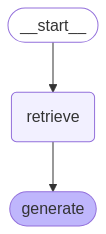

In [29]:
from IPython.display import Image, display  # Tools to display images in Jupyter

# --- Display a flowchart-style diagram of your LangGraph ---
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
# --- Run the RAG pipeline with a test question ---
result = graph.invoke({"question": "What is Task Decomposition?"})

# --- Print the retrieved context (the text chunks from the document) ---
print(f'Context: {result["context"]}\n\n')

# --- Print the final generated answer from the model ---
print(f'Answer: {result["answer"]}')

Context: [Document(id='66dbce2b-308a-4a1c-8ec4-aec1fac8f799', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='4bec8aec-0f3e-4f0f-955f-445f9e77e914', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent

In [33]:
# --- Stream execution of the RAG app step-by-step using LangGraph ---

# This mode lets you see the intermediate results from each step in the graph,
# such as the documents retrieved by the 'retrieve' node, followed by the generated answer.

for step in graph.stream(
    {"question": "What is Task Decomposition?"},  # Input question
    stream_mode="updates"  # Stream updates after each graph step (node)
):
    # Print each update from the graph (retrieval, then generation)
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='66dbce2b-308a-4a1c-8ec4-aec1fac8f799', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='4bec8aec-0f3e-4f0f-955f-445f9e77e914', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent sy

In [35]:
# --- Stream token-level output from the final answer (LLM response) ---

# This allows you to simulate real-time typing or streaming in chat-like UIs
# Each `message.content` will contain part of the generated answer

for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"},  # The input question
    stream_mode="messages"  # Stream individual message chunks from the LLM
):
    print(message.content, end="|")  # Print each token-like chunk, separated by "|"

|Task| De|composition| is| the| process| of| breaking| down| a| complex| task| into| smaller|,| more| manageable| steps|.| This| can| be| achieved| through| techniques| like| Chain| of| Thought| (|Co|T|),| which| encourages| models| to| think| step| by| step|,| or| by| using| task|-specific| prompts|.| It| helps| enhance| model| performance| by| clar|ifying| the| reasoning| process| involved| in| tackling| hard| tasks|.||

In [37]:
from langchain_core.prompts import PromptTemplate  # Import prompt utility

# --- Define your custom RAG prompt ---
# This version enforces:
# - Conciseness
# - No guessing
# - A polite tone
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""

# --- Create a LangChain PromptTemplate object ---
custom_rag_prompt = PromptTemplate.from_template(template)

In [39]:
# --- Simulate adding metadata to your document chunks ---
# This divides your content into three sections so we can apply filters later

total_documents = len(all_splits)      # Total number of document chunks
third = total_documents // 3           # Divide into thirds for metadata assignment

# Assign a "section" label to each document chunk based on its position
for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

# --- Inspect metadata for the first chunk to verify it was applied correctly ---
all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [41]:
from langchain_core.vectorstores import InMemoryVectorStore  # Import the simple in-memory store

# --- Reinitialize the vector store with metadata-enabled document chunks ---
vector_store = InMemoryVectorStore(embeddings)  # Pass in your embedding model

# --- Re-index all the document splits, now with section metadata ---
_ = vector_store.add_documents(all_splits)  # Store new version of docs with metadata

In [43]:
from typing import Literal  # Used to restrict a field to specific values
from typing_extensions import Annotated  # Adds metadata (descriptions) to types

# --- Define the structured schema for a search query ---
# This will be used to extract structured data from an LLM output

class Search(TypedDict):
    """Search query."""

    # The actual query we will use in similarity search
    query: Annotated[str, ..., "Search query to run."]

    # Section of the document to filter on (metadata filter)
    section: Annotated[
        Literal["beginning", "middle", "end"],  # Restrict valid values
        ...,  # Required field
        "Section to query.",
    ]

In [45]:
from typing_extensions import TypedDict
from langchain_core.documents import Document

# --- Update your State to include the structured query object ---
class State(TypedDict):
    question: str                    # Raw user input
    query: Search                    # Structured query (with filter)
    context: List[Document]         # Retrieved chunks
    answer: str                      # Final model output

# --- New Step: Analyze the raw question to produce a structured query object ---
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)  # Tell the LLM to return a structured object
    query = structured_llm.invoke(state["question"])     # LLM analyzes the question and returns query + section
    return {"query": query}                              # Inject this into the graph state

# --- Modified Retrieval Step: Uses structured query + metadata filter ---
def retrieve(state: State):
    query = state["query"]  # Extract structured query
    retrieved_docs = vector_store.similarity_search(
        query["query"],  # Use the rewritten/cleaned query string
        filter=lambda doc: doc.metadata.get("section") == query["section"]  # Filter by section metadata
    )
    return {"context": retrieved_docs}

# --- Generation Step: Same as before ---
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

# --- Update the Graph ---
# Add 'analyze_query' as the new first step before retrieval and generation
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")  # Start the graph at the new step
graph = graph_builder.compile()  # Compile into an executable workflow

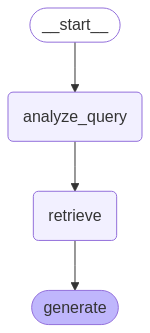

In [47]:
from IPython.display import Image, display  # Import tools to display images in Jupyter

# --- Visualize your LangGraph as a Mermaid diagram ---
# This helps you see the step-by-step flow of your application:
# START -> analyze_query -> retrieve -> generate

display(
    Image(graph.get_graph().draw_mermaid_png())  # Render the graph as a PNG image using Mermaid
)

In [49]:
# --- Stream each step in your LangGraph RAG pipeline ---
# This shows the intermediate state after each node runs:
# - analyze_query: returns structured query with section
# - retrieve: returns context chunks based on that section
# - generate: returns final LLM-generated answer

for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},  # Input question
    stream_mode="updates",  # Stream state updates after each graph node
):
    print(f"{step}\n\n----------------\n")  # Show each step's result, separated visually

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='73adfb4f-3203-499c-8268-ce4867880e7a', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39220, 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adj